In [1]:
suppressPackageStartupMessages(library(CellChat))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(Matrix))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(reshape2))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(rafalib))

In [2]:
CelltypeColors=c('B-cell'='#1f77b4','NK'='#ff7f0e','T CD4 memory'='#279e68','T CD4 naive'='#d62728',
                 'T CD8 memory'='#aa40fc','T CD8 naive'= '#8c564b','Treg'='#e377c2',
                 'endothelial'= '#b5bd61','epithelial'= '#17becf','fibroblast'= '#aec7e8',
                 'mDC'= '#ffbb78','macrophage'= '#98df8a','mast'= '#ff9896','monocyte'='#c5b0d5',
                 'neutrophil'= '#c49c94','pDC'= '#f7b6d2','plasmablast'= '#dbdb8d','tumor'= '#9edae5')

In [3]:
options(repr.plot.width=16, repr.plot.height=8,warn = -1) #warn = 1

In [4]:
my_computeCommunProb <- function(object,P.spatial,  type = c("triMean", "truncatedMean","thresholdedMean", "median"), trim = 0.1, LR.use = NULL, raw.use = TRUE, population.size = FALSE,
                                 interaction.length = 200, scale.distance = 0.01, k.min = 10,
                              nboot = 100, seed.use = 1L, Kh = 0.5, n = 1) {
  type <- match.arg(type)
  cat(type, "is used for calculating the average gene expression per cell group.", "\n")
  FunMean <- switch(type,
                    triMean = triMean,
                    truncatedMean = function(x) mean(x, trim = trim, na.rm = TRUE),
                    median = function(x) median(x, na.rm = TRUE))

  if (raw.use) {
    data <- as.matrix(object@data.signaling)
  } else {
    data <- object@data.project
  }
  if (is.null(LR.use)) {
    pairLR.use <- object@LR$LRsig
  } else {
    pairLR.use <- LR.use
  }
  complex_input <- object@DB$complex
  cofactor_input <- object@DB$cofactor
  # my.sapply <- ifelse(
  #     test = future::nbrOfWorkers() == 1,
  #     yes = sapply,
  #     no = future.apply::future_sapply
  # )
  my.sapply <- future.apply::future_sapply

  ptm = Sys.time()

  pairLRsig <- pairLR.use
  group <- object@idents
  geneL <- as.character(pairLRsig$ligand)
  geneR <- as.character(pairLRsig$receptor)
  nLR <- nrow(pairLRsig)
  numCluster <- nlevels(group)
  if (numCluster != length(unique(group))) {
    stop("Please check `unique(object@idents)` and ensure that the factor levels are correct!
         You may need to drop unused levels using 'droplevels' function. e.g.,
         `meta$labels = droplevels(meta$labels, exclude = setdiff(levels(meta$labels),unique(meta$labels)))`")
  }
  # if (all(data[1:5, ] == floor(data[1:5, ]))) {
  #   stop("Please check your input data matrix and ensure that you use the normalized data instead of count data!")
  # }


  data.use <- data/max(data)
  nC <- ncol(data.use)

  # compute the average expression per group
  data.use.avg <- aggregate(t(data.use), list(group), FUN = FunMean)
  data.use.avg <- t(data.use.avg[,-1])
  colnames(data.use.avg) <- levels(group)
  # compute the expression of ligand or receptor
  dataLavg <- computeExpr_LR(geneL, data.use.avg, complex_input)
  dataRavg <- computeExpr_LR(geneR, data.use.avg, complex_input)
  # take account into the effect of co-activation and co-inhibition receptors
  dataRavg.co.A.receptor <- computeExpr_coreceptor(cofactor_input, data.use.avg, pairLRsig, type = "A")
  dataRavg.co.I.receptor <- computeExpr_coreceptor(cofactor_input, data.use.avg, pairLRsig, type = "I")
  dataRavg <- dataRavg * dataRavg.co.A.receptor/dataRavg.co.I.receptor

  dataLavg2 <- t(replicate(nrow(dataLavg), as.numeric(table(group))/nC))
  dataRavg2 <- dataLavg2

  # compute the expression of agonist and antagonist
  index.agonist <- which(!is.na(pairLRsig$agonist) & pairLRsig$agonist != "")
  index.antagonist <- which(!is.na(pairLRsig$antagonist) & pairLRsig$antagonist != "")
  # quantify the communication probability

  # compute the spatial constraint
  d.spatial <- matrix(NaN, nrow = numCluster, ncol = numCluster)
  # P.spatial <- matrix(1, nrow = numCluster, ncol = numCluster)
  # P.spatial[is.na(d.spatial)] <- 0
  P.spatial=P.spatial[levels(group),levels(group)]
  P.spatial=as.matrix(P.spatial)
  # P.spatial<-P.spatial/scale.distance
                    
  Prob <- array(0, dim = c(numCluster,numCluster,nLR))
  Pval <- array(0, dim = c(numCluster,numCluster,nLR))

  set.seed(seed.use)
  permutation <- replicate(nboot, sample.int(nC, size = nC))
  data.use.avg.boot <- my.sapply(
    X = 1:nboot,
    FUN = function(nE) {
      groupboot <- group[permutation[, nE]]
      data.use.avgB <- aggregate(t(data.use), list(groupboot), FUN = FunMean)
      data.use.avgB <- t(data.use.avgB[,-1])
      return(data.use.avgB)
    },
    simplify = FALSE
  )
  pb <- txtProgressBar(min = 0, max = nLR, style = 3, file = stderr())

  for (i in 1:nLR) {
    # ligand/receptor
    dataLR <- Matrix::crossprod(matrix(dataLavg[i,], nrow = 1), matrix(dataRavg[i,], nrow = 1))
    P1 <- dataLR^n/(Kh^n + dataLR^n)
    P1_Pspatial <- P1*P.spatial
    if (sum(P1_Pspatial) == 0) {
      Pnull = P1_Pspatial
      Prob[ , , i] <- Pnull
      p = 1
      Pval[, , i] <- matrix(p, nrow = numCluster, ncol = numCluster, byrow = FALSE)
    } else {
      # agonist and antagonist
      if (is.element(i, index.agonist)) {
        data.agonist <- computeExpr_agonist(data.use = data.use.avg, pairLRsig, cofactor_input, index.agonist = i, Kh = Kh,  n = n)
        P2 <- Matrix::crossprod(matrix(data.agonist, nrow = 1))
      } else {
        P2 <- matrix(1, nrow = numCluster, ncol = numCluster)
      }
      if (is.element(i, index.antagonist)) {
        data.antagonist <- computeExpr_antagonist(data.use = data.use.avg, pairLRsig, cofactor_input,  index.antagonist = i, Kh = Kh,  n = n)
        P3 <- Matrix::crossprod(matrix(data.antagonist, nrow = 1))
      } else {
        P3 <- matrix(1, nrow = numCluster, ncol = numCluster)
      }
      # number of cells
      if (population.size) {
        P4 <- Matrix::crossprod(matrix(dataLavg2[i,], nrow = 1), matrix(dataRavg2[i,], nrow = 1))
      } else {
        P4 <- matrix(1, nrow = numCluster, ncol = numCluster)
      }

      # Pnull = P1*P2*P3*P4
      Pnull = P1*P2*P3*P4*P.spatial
      Prob[ , , i] <- Pnull

      Pnull <- as.vector(Pnull)

      #Pboot <- foreach(nE = 1:nboot) %dopar% {
      Pboot <- sapply(
        X = 1:nboot,
        FUN = function(nE) {
          data.use.avgB <- data.use.avg.boot[[nE]]
          dataLavgB <- computeExpr_LR(geneL[i], data.use.avgB, complex_input)
          dataRavgB <- computeExpr_LR(geneR[i], data.use.avgB, complex_input)
          # take account into the effect of co-activation and co-inhibition receptors
          dataRavgB.co.A.receptor <- computeExpr_coreceptor(cofactor_input, data.use.avgB, pairLRsig[i, , drop = FALSE], type = "A")
          dataRavgB.co.I.receptor <- computeExpr_coreceptor(cofactor_input, data.use.avgB, pairLRsig[i, , drop = FALSE], type = "I")
          dataRavgB <- dataRavgB * dataRavgB.co.A.receptor/dataRavgB.co.I.receptor
          dataLRB = Matrix::crossprod(dataLavgB, dataRavgB)
          P1.boot <- dataLRB^n/(Kh^n + dataLRB^n)
          # agonist and antagonist
          if (is.element(i, index.agonist)) {
            data.agonist <- computeExpr_agonist(data.use = data.use.avgB, pairLRsig, cofactor_input, index.agonist = i, Kh = Kh,  n = n)
            P2.boot <- Matrix::crossprod(matrix(data.agonist, nrow = 1))
          } else {
            P2.boot <- matrix(1, nrow = numCluster, ncol = numCluster)
          }
          if (is.element(i, index.antagonist)) {
            data.antagonist <- computeExpr_antagonist(data.use = data.use.avgB, pairLRsig, cofactor_input, index.antagonist = i, Kh = Kh,  n= n)
            P3.boot <- Matrix::crossprod(matrix(data.antagonist, nrow = 1))
          } else {
            P3.boot <- matrix(1, nrow = numCluster, ncol = numCluster)
          }

          if (population.size) {
            groupboot <- group[permutation[, nE]]
            dataLavg2B <- as.numeric(table(groupboot))/nC
            dataLavg2B <- matrix(dataLavg2B, nrow = 1)
            dataRavg2B <- dataLavg2B
            P4.boot = Matrix::crossprod(dataLavg2B, dataRavg2B)
          } else {
            P4.boot = matrix(1, nrow = numCluster, ncol = numCluster)
          }

          #  Pboot = P1.boot*P2.boot*P3.boot*P4.boot
          Pboot = P1.boot*P2.boot*P3.boot*P4.boot*P.spatial
          return(as.vector(Pboot))
        }
      )
      Pboot <- matrix(unlist(Pboot), nrow=length(Pnull), ncol = nboot, byrow = FALSE)
      nReject <- rowSums(Pboot - Pnull > 0)
      p = nReject/nboot
      Pval[, , i] <- matrix(p, nrow = numCluster, ncol = numCluster, byrow = FALSE)
    }
    setTxtProgressBar(pb = pb, value = i)
  }
  close(con = pb)
  Pval[Prob == 0] <- 1
  dimnames(Prob) <- list(levels(group), levels(group), rownames(pairLRsig))
  dimnames(Pval) <- dimnames(Prob)
  net <- list("prob" = Prob, "pval" = Pval)
  execution.time = Sys.time() - ptm
  object@options$run.time <- as.numeric(execution.time, units = "secs")
  distance.use = NULL; interaction.length = NULL; spot.size = NULL; spot.size.fullres = NULL; k.min = NULL;
  object@options$parameter <- list(type.mean = type, trim = trim, raw.use = raw.use, population.size = population.size,  nboot = nboot, seed.use = seed.use, Kh = Kh, n = n,
                                distance.use = distance.use,interaction.length = interaction.length, spot.size = spot.size, spot.size.fullres = spot.size.fullres, k.min = k.min
                                   )
  object@images$distance <- d.spatial
  object@net <- net
  print(paste0('>>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [', Sys.time(),']'))
  return(object)
}

# cellchat object

In [5]:
metadata=read.table('data/NSCLC_metadata_CC3.csv',sep=',',row.names=1,header=1)
data.input=as.matrix(read.csv('data/NSCLC_expr_CC3.csv',row.names=1))
cellchat3 <- createCellChat(object = data.input, meta = metadata, group.by = "celltype")
P.spatial3=read.csv('data/NSCLC_CC3_prob.csv',row.names=1)
colnames(P.spatial3)=rownames(P.spatial3)

[1] "Create a CellChat object from a data matrix"
Set cell identities for the new CellChat object 
The cell groups used for CellChat analysis are  B-cell endothelial epithelial fibroblast macrophage mast mDC monocyte neutrophil NK pDC plasmablast T CD4 memory T CD4 naive T CD8 memory T CD8 naive Treg tumor 


In [6]:
# Set the ligand-receptor interaction database
CellChatDB <- CellChatDB.human
CellChatDB.use <- CellChatDB 
cellchat3@DB <- CellChatDB.use

# Preprocessing the expression data for cell-cell communication analysis
cellchat3 <- subsetData(cellchat3)
cellchat3 <- identifyOverExpressedGenes(cellchat3)
cellchat3 <- identifyOverExpressedInteractions(cellchat3)
cellchat3 <- projectData(cellchat3, PPI.human)

# Compute the communication probability and infer cellular communication network
cellchat3 <- my_computeCommunProb(cellchat3,P.spatial3, raw.use = TRUE)

# Filter out the cell-cell communication if there are only few number of cells in certain cell groups
cellchat3 <- filterCommunication(cellchat3, min.cells = 10)

# Infer the cell-cell communication at a signaling pathway level
cellchat3 <- computeCommunProbPathway(cellchat3)

# Calculate the aggregated cell-cell communication network
cellchat3 <- aggregateNet(cellchat3)

# Compute the network centrality scores
cellchat3 <- netAnalysis_computeCentrality(cellchat3, slot.name = "netP")

triMean is used for calculating the average gene expression per cell group. 
[1] ">>> CellChat inference is done. Parameter values are stored in `object@options$parameter` <<< [2023-12-19 14:27:16]"


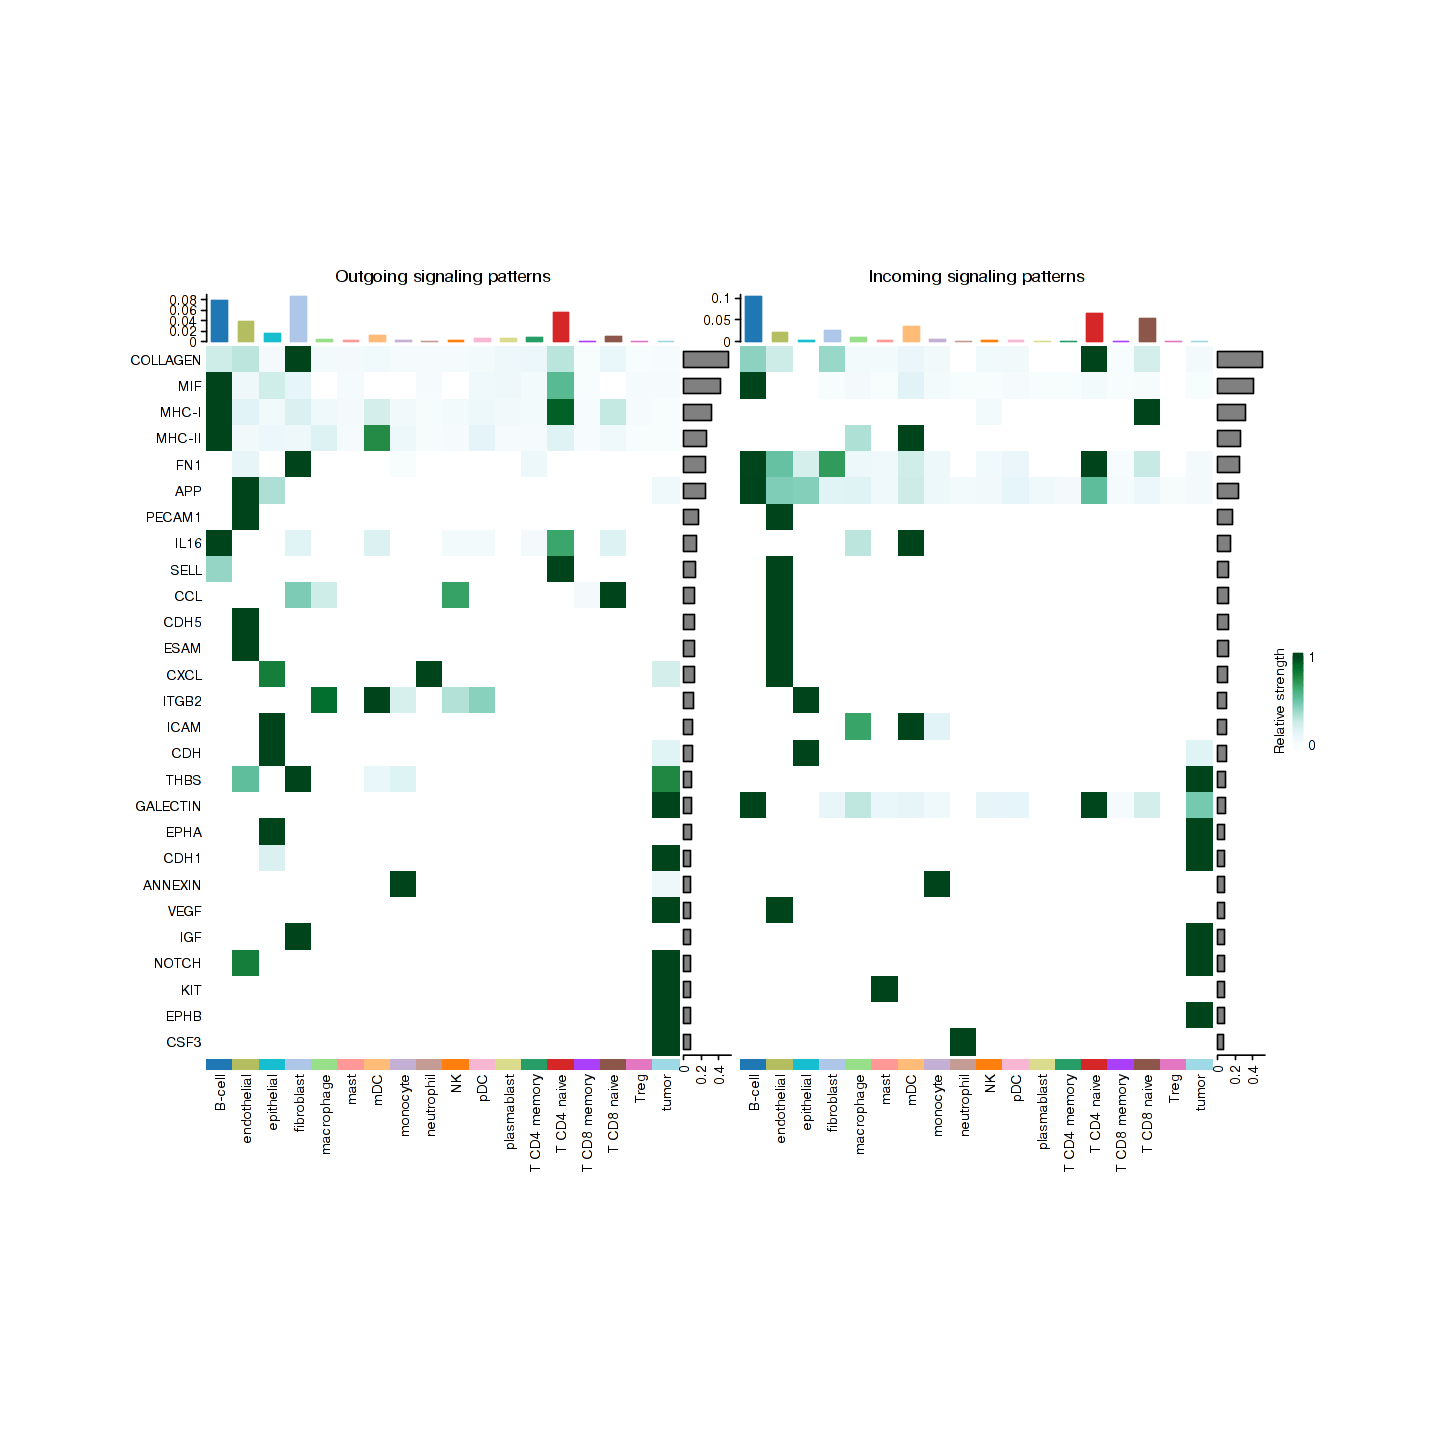

In [7]:
# Signaling role analysis on the aggregated cell-cell communication network from all signaling pathways
ht1 <- netAnalysis_signalingRole_heatmap(cellchat3,width = 10,height = 15,font.size = 8,pattern = "outgoing",
                                         color.use=unname(CelltypeColors[levels(cellchat3@idents)]),)
ht2 <- netAnalysis_signalingRole_heatmap(cellchat3, width = 10,height = 15,font.size = 8,pattern = "incoming",
                                         color.use=unname(CelltypeColors[levels(cellchat3@idents)]),) # OrRd
ht1 + ht2

Do heatmap based on a single object 




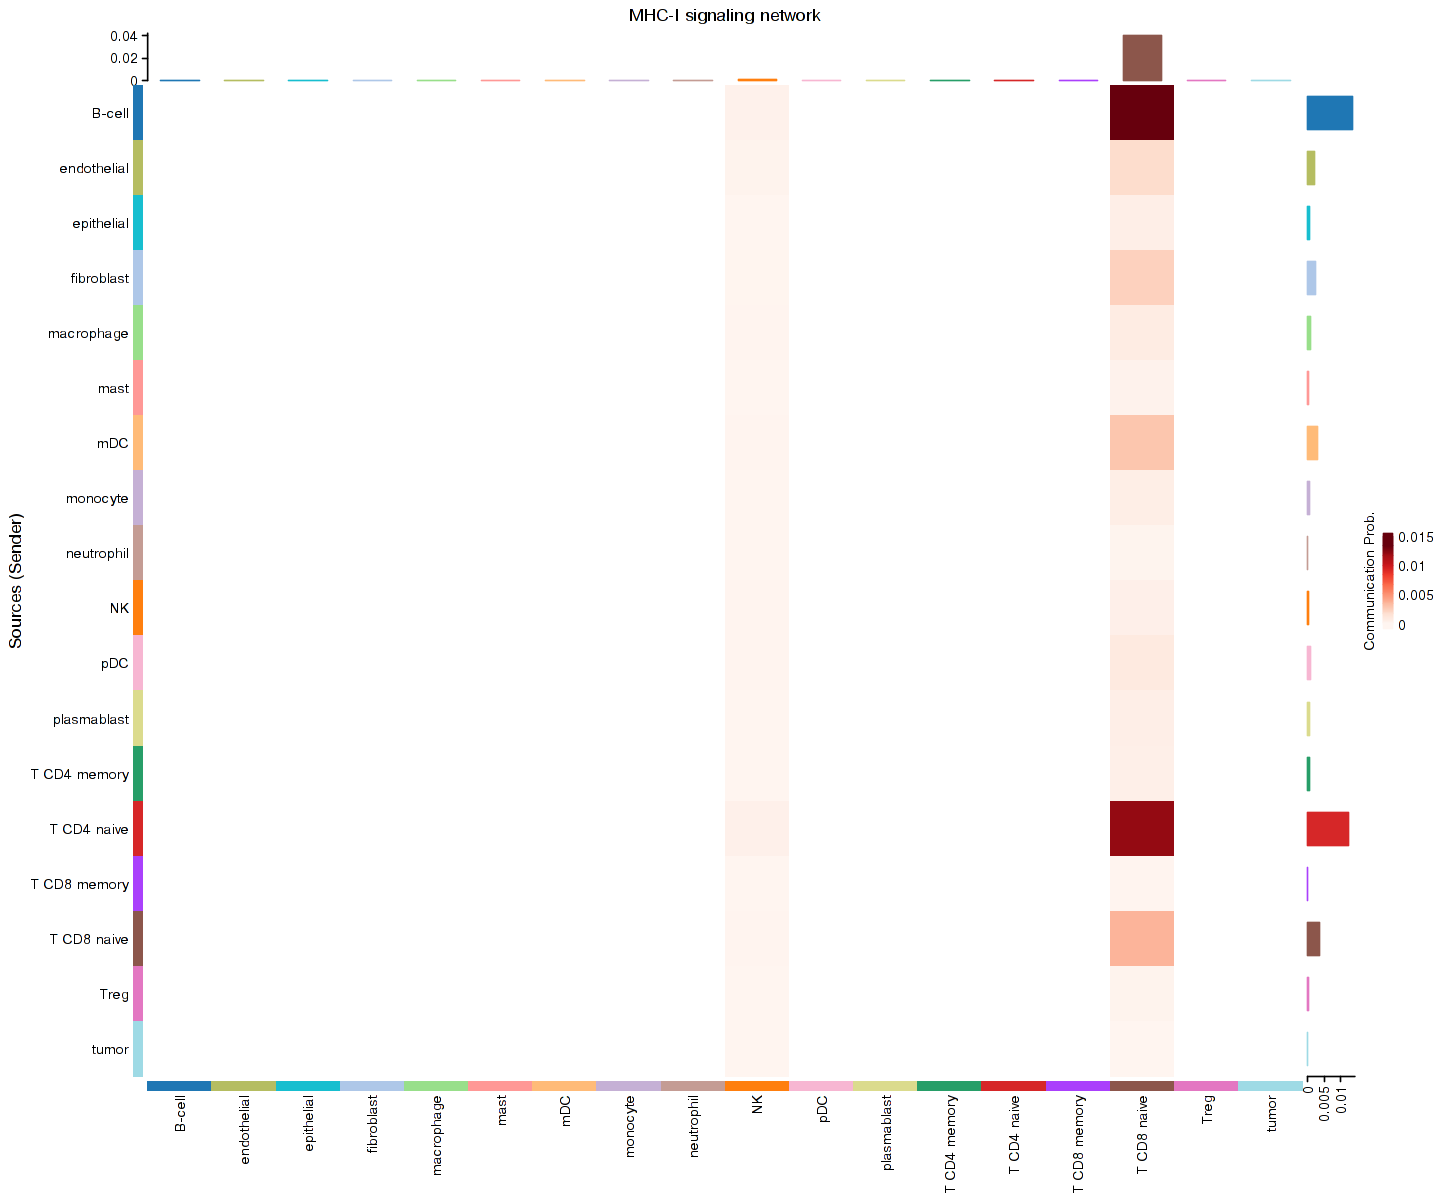

In [10]:
options(repr.plot.width=12, repr.plot.height=10,warn = -1) 
netVisual_heatmap(cellchat3, signaling = "MHC-I", color.heatmap = "Reds",color.use=unname(CelltypeColors[levels(cellchat3@idents)]))

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


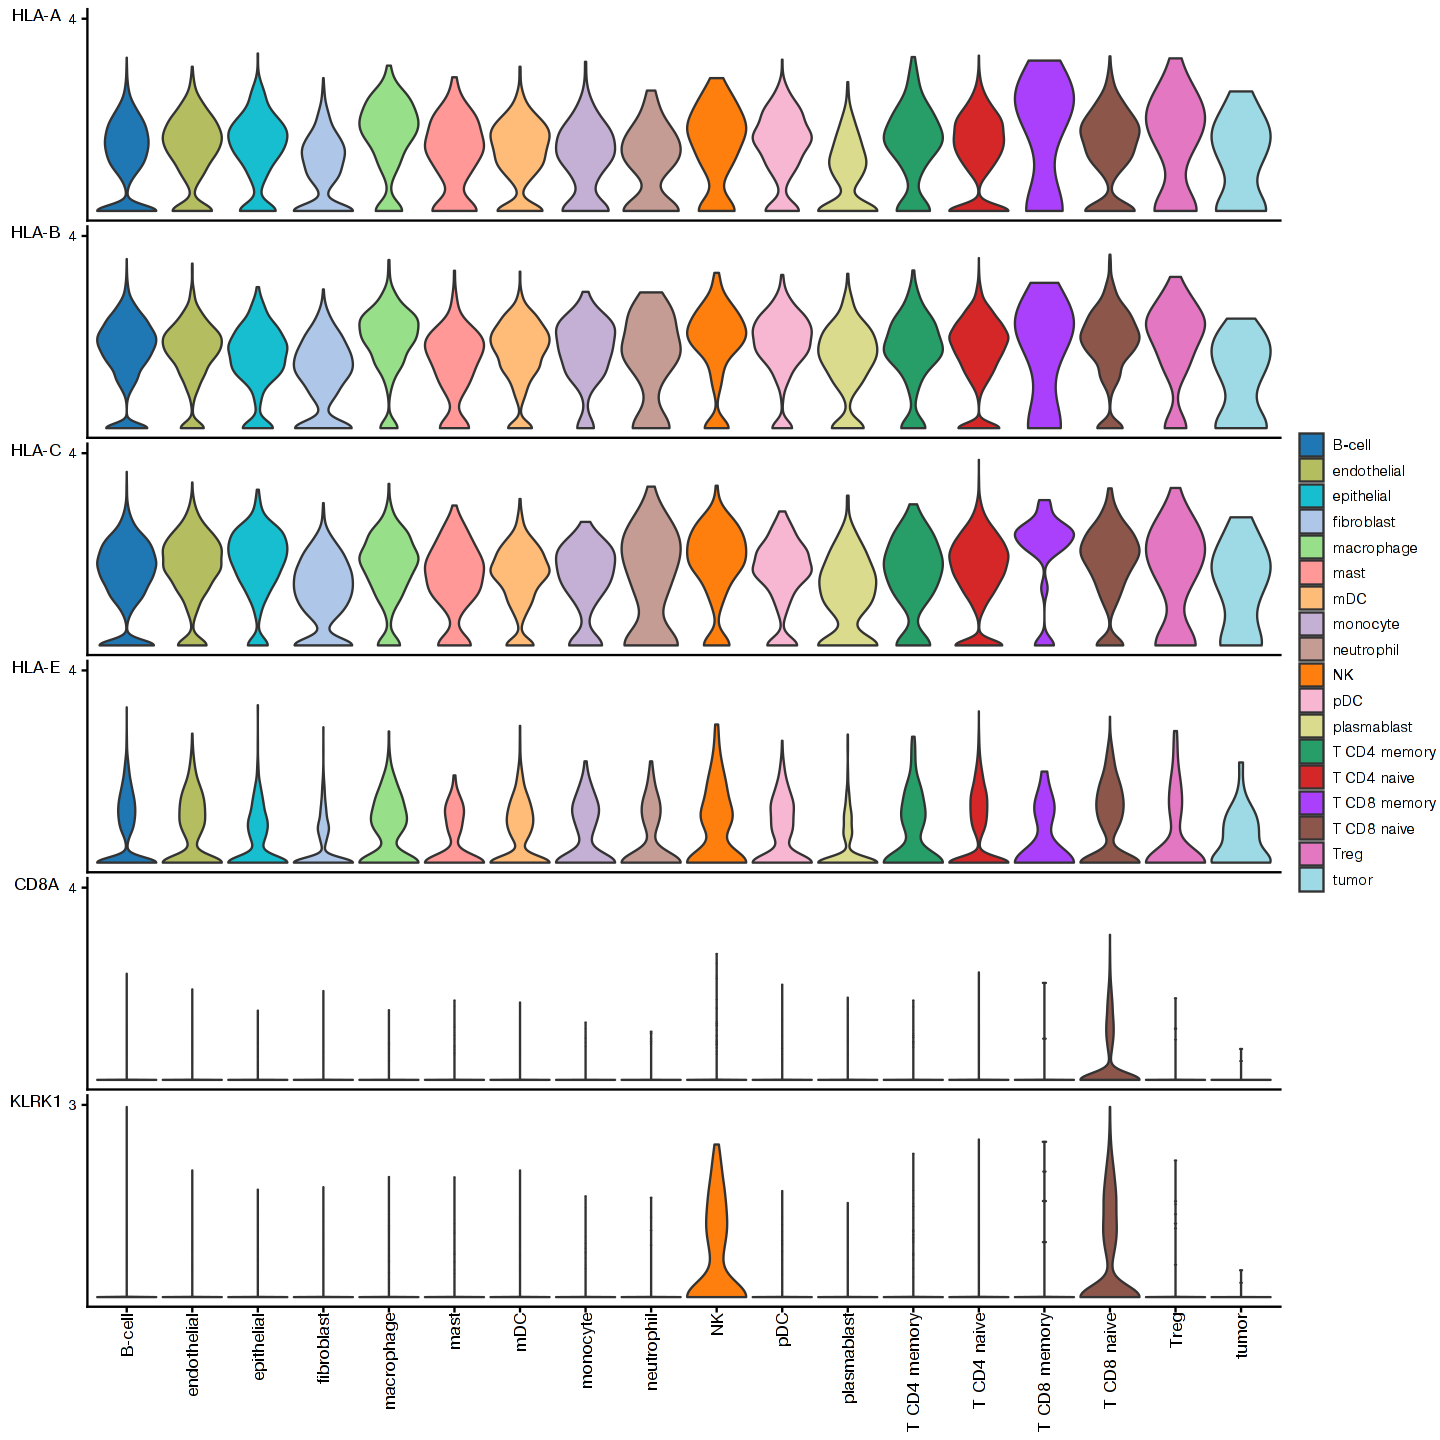

In [9]:
plotGeneExpression(cellchat3,signaling = c('MHC-I'),enriched.only = TRUE,
                   color.use=unname(CelltypeColors[levels(cellchat3@idents)]))